In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import torch.nn.functional as F
import torchvision.transforms as T
import torchvision.datasets
import torchvision.transforms as transforms

import numpy as np

In [2]:
import cv2
import pandas as pd
import os
import matplotlib.pyplot as plt

In [3]:
labels = ['Abyssinian', 'American', "Silkie", 'Skinny']

In [4]:
train_data = pd.read_csv("./cavy_breed_clf/data/cavy_data_train.csv")
val_data = pd.read_csv("./cavy_breed_clf/data/cavy_data_val.csv")
test_data = pd.read_csv("./cavy_breed_clf/data/cavy_data_test.csv")

In [5]:
train_data.head()

,image_path,breed
0,images/American/american_2143.jpg,American
1,images/American/piggy_301.jpg,American
2,images/Abyssinian/abyssinian_1653.jpg,Abyssinian
3,images/Abyssinian/abyssinian_1318.jpg,Abyssinian
4,images/American/american_212.jpg,American


In [6]:
val_data.head()

,image_path,breed
0,images/Silkie/silkie_692.jpg,Silkie
1,images/Skinny/skinny_248.jpg,Skinny
2,images/Abyssinian/abyssinian_1387.jpg,Abyssinian
3,images/Abyssinian/piggy_328.jpg,Abyssinian
4,images/American/american_2024.jpg,American


In [7]:
test_data.head()

,image_path,breed
0,images/Skinny/skinny_294.jpg,Skinny
1,images/Abyssinian/abyssinian_083.jpg,Abyssinian
2,images/Abyssinian/abyssinian_1592.jpg,Abyssinian
3,images/Skinny/skinny_281.jpg,Skinny
4,images/American/american_040.jpg,American


In [8]:
path, label = train_data["image_path"], train_data["breed"]


In [9]:
image_sample = cv2.imread(os.path.join('./cavy_breed_clf', path[0]))

In [10]:
# images = np.asarray([cv2.imread(path_item) for path_item in path])
train_set = []
for path_item in path:
    image = cv2.imread(os.path.join('./cavy_breed_clf', path_item))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (150, 150))
    train_set.append(image)
    
    
train_set = np.array(train_set)
    

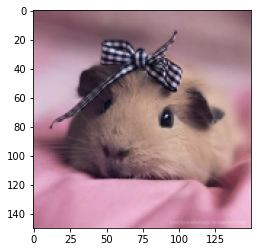

In [11]:
plt.imshow(train_set[0])

In [12]:
class cherry_dataset(Dataset):
    def __init__(self, csv_path, transform = None):
        self.dataframe = pd.read_csv(csv_path)
        images, self.labels = self.dataframe["image_path"], self.dataframe["breed"]
        self.image_set = []
        for image in images:
            image_file = cv2.imread(os.path.join('./cavy_breed_clf', image))
            image_file = cv2.cvtColor(image_file, cv2.COLOR_BGR2RGB)
            image_file = cv2.resize(image_file, (150, 150))
            self.image_set.append(image_file)
            
        self.image_set = np.array(self.image_set)
        self.transform = transform
        
    def __len__(self):
        return len(self.dataframe)
    
    def __getitem__(self, idx):
        image = self.image_set[idx]
        label = self.labels[idx]
        if label == "Skinny":
            label = 0
        elif label == "Abyssinian":
            label = 1
        elif label == "American":
            label = 2
        else:
            label = 3
        if self.transform:
            sample = self.transform(image), label
        else:
            sample = iamge, label
            
        return sample
            

In [13]:
class ToTensor(object):
    def __call__(self, sample):
        image, label = sample
        iamge = image.transpose((2,0,1))
        
        return torch.from_numpy(image),  torch.tensor(label)
    
class Normalize(object):
    def __call__(self, sample):
        image, label = sample
        image = T.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
        return image, label

In [14]:
train_transform = transform = T.Compose([
                T.RandomCrop(120),
                T.RandomHorizontalFlip(),
                T.RandomRotation(90),
                T.ColorJitter(),
                T.ToTensor(),
                T.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
            ])

train_set = cherry_dataset(csv_path = "./cavy_breed_clf/data/cavy_data_train.csv", transform=train_transform)
val_set = cherry_dataset(csv_path = "./cavy_breed_clf/data/cavy_data_val.csv", transform=transform)
test_set = cherry_dataset(csv_path = "./cavy_breed_clf/data/cavy_data_test.csv", transform=transform)

In [15]:
type(train_set)

__main__.cherry_dataset

In [16]:
batch_size = 32
loader_train = DataLoader(train_set, batch_size = batch_size, shuffle=True)
loader_val = DataLoader(val_set, batch_size = batch_size, shuffle=True)
loader_test = DataLoader(test_set, batch_size = batch_size, shuffle=True)


In [17]:
print(enumerate(loader_train))

In [18]:
USE_GPU = True
num_class = 4
dtype = torch.float32 # we will be using float throughout this tutorial

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

# Constant to control how frequently we print train loss
print_every = 100

print('using device:', device)

using device: cuda


In [19]:
def check_accuracy_part34(loader, model):
    
    num_correct = 0
    num_samples = 0
    model.eval()  # set model to evaluation mode
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.long)
            scores = model(x)
            _, preds = scores.max(1)
            num_correct += (preds == y).sum()
            num_samples += preds.size(0)
        acc = float(num_correct) / num_samples
        print('Got %d / %d correct (%.2f)' % (num_correct, num_samples, 100 * acc))
    return acc

In [20]:
def trainer(model, optimizer, epoch = 10):
    model = model.to(device = device)
    for e in range(epoch):
#         num_correct = 0
#         num_samples = 0
        for batch_idx, (image, label) in enumerate(loader_train):
            model.train()
            image = image.to(device = device, dtype = dtype)
            label = label.to(device = device, dtype = torch.long)
            scores = model(image)
            _, preds = scores.max(1)
            loss = F.cross_entropy(scores, label)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
#             num_correct += (preds == label).sum()
#             num_samples += preds.size(0)
            
            if batch_idx % print_every == 0:
                print("Epoch %d Iteration %d: Loss = %.4f" % (e, batch_idx, loss.item()))
                check_accuracy_part34(loader_val, model)
#                 acc = float(num_correct) / num_samples
#                 print('Got %d / %d correct (%.2f)' % (num_correct, num_samples, 100 * acc))
                print()

In [21]:
class BasicBlock(nn.Module):
    def __init__(self, in_channel, out_channel, stride = 1, BN = False):
        super(BasicBlock, self).__init__()
        self.BN = BN
        self.conv1 = nn.Conv2d(in_channel, out_channel, kernel_size = 3, stride = stride, padding = 1, bias = False)
        self.bn1 = nn.BatchNorm2d(out_channel)
        self.conv2 = nn.Conv2d(out_channel, out_channel, kernel_size = 3, padding = 1, bias = False)
        self.bn2 = nn.BatchNorm2d(out_channel)
        self.shortcut = nn.Sequential()
        self.relu = nn.ReLU()
        if stride != 1 or in_channel != out_channel:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channel, out_channel, kernel_size=1, stride=stride, bias = False),
                nn.BatchNorm2d(out_channel)
            )
        
    def forward(self, x):
        if self.BN is True:
            out = self.relu(self.bn1(self.conv1(x)))
            out = self.bn2(self.conv2(out))
            out += self.shortcut(x)
            out = self.relu(out)
        else:
            out = self.relu(self.conv1(x))
            out = self.conv2(out)
            out += self.shortcut(x)
            out = self.relu(out)
            
        return out

class ResNet(nn.Module):
    
    def __init__(self, BN = False):
        super(ResNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, 7, 2, 3)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(3, 2, 1)
        self.conv2_x = BasicBlock(64, 64, 1, BN)
        self.conv3_x = BasicBlock(64, 128, 1, BN)
        self.conv4_x = BasicBlock(128, 256, 1, BN)
        self.conv5_x = BasicBlock(256, 512, 2, BN)
        self.final = nn.Sequential(
            nn.AvgPool2d(4),
            nn.Flatten(),
            nn.Linear(8192, 4)
        )
        
    def forward(self, x):
        out = self.relu(self.conv1(x))
        out = self.maxpool(out)
        out = self.conv2_x(out)
        out = self.conv3_x(out)
        out = self.conv4_x(out)
        out = self.conv5_x(out)
        out = self.final(out)
        
        
        return out

In [22]:
learning_rate = 1e-3

model = ResNet(BN = True)
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate, betas = (0.9, 0.999), eps = 1e-08)

In [23]:
trainer(model, optimizer, 10)

TypeError: Unexpected type <class 'numpy.ndarray'>

In [ ]:
check_accuracy_part34(loader_test, model)

In [ ]:
model2 = ResNet(BN = True)
optimizer = torch.optim.Adam(model2.parameters(), lr = learning_rate, betas = (0.9, 0.999), eps = 1e-08)
trainer(model2, optimizer, 10)

In [ ]:
check_accuracy_part34(loader_test, model2)